In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [3]:
def rand_numb(low_in,high_in):
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

#just to keep the upper limit included in the random number generation. 

In [4]:
def append(list1, list2):
    temp = []
    temp.extend(list1)
    temp.extend(list2)
    return temp

In [36]:
numLayer = 2
numQubit = 1
global iterations
global noisy

In [23]:
def createProver(numQubit, numLayer):
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

In [7]:
#Create unitaries here
unitary_param_1 = np.array([])
#for i in range(0, 8):
#    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))
 
unitary_param_1 = [1.86051851, 3.72215261, 1.57043552, 5.48869762, 
                   2.30980358, 5.01476937, 0.5581273, 3.88907588]

In [20]:
def createEqSuperposIZ():
    temp = QuantumCircuit(1)
    temp.h(0)
    return temp

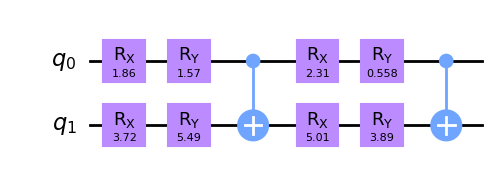

In [21]:
# First unitary
size = 2
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

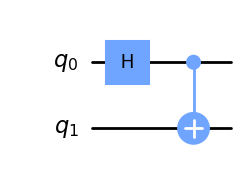

In [203]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw('mpl')

In [204]:
def createQuantumCircuit(numQubit, numLayer):
    circ = QuantumCircuit(3)
    #Create Quantum Circuit here
    
    superPosCircuit = createEqSuperposIZ()
    circ.append(superPosCircuit, [0])
    
    circ.append(qc, [1, 2])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [2])
    
    circ.cz(0, 1)
    circ.cz(0, 2)
    
    circ.append(superPosCircuit.inverse(), [0])
    
    return circ

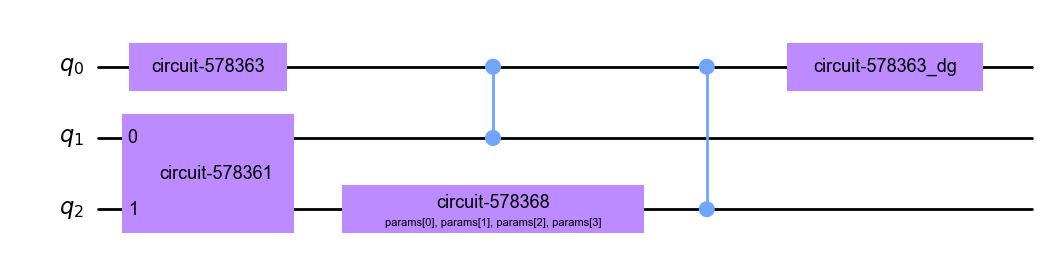

In [205]:
qCirc = createQuantumCircuit(numQubit, numLayer)
qCirc.draw('mpl')

In [206]:
#use if noiseless
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [208]:
#Use if noisy
provider = IBMQ.get_provider(hub='ibm-q')
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_lima")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [209]:
#Create Hamiltonian here
hamiltonian = I^I^MatrixOp(np.array([[1, 0], [0, 0]]))

In [210]:
def costf(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [211]:
def gradient(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [212]:
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3])])


In [213]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [214]:
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[0.79996888 0.10890809 1.28160788 1.68169045]
Initial Cost :  0.4894831900728533


In [215]:
true_value = 0.9999957258028627

In [216]:
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.4894831900728533
Loss Value :  0.3872432701242221 1.0%
Loss Value :  0.43869753787203547 2.0%
Loss Value :  0.45646033138317116 3.0%
Loss Value :  0.8608918183183809 4.0%
Loss Value :  0.8296542765852774 5.0%
Loss Value :  0.8380768312432842 6.0%
Loss Value :  0.9694204673057086 7.0%
Loss Value :  0.9801263392523349 8.0%
Loss Value :  0.9806908622608157 9.0%
Loss Value :  0.9809624453490686 10.0%
Loss Value :  0.990581324892456 11.0%
Loss Value :  0.9958001952063991 12.0%
Loss Value :  0.9960298641881774 13.0%
Loss Value :  0.9969390180574929 14.0%
Loss Value :  0.9983651409498466 15.0%
Loss Value :  0.998535896548134 16.0%
Loss Value :  0.9985515875463135 17.0%
Loss Value :  0.9986254352165667 18.0%
Loss Value :  0.9991804773358264 19.0%
Loss Value :  0.9995742685361697 20.0%
Loss Value :  0.9995825717201859 21.0%
Loss Value :  0.9998432647756019 22.0%
Loss Value :  0.9998786068700268 23.0%
Loss Value :  0.9999467195034077 24.0%
Loss Value :  0.999936559051272 25.0%


In [217]:
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.4922340341240651
Loss Value :  0.5019599846211596 1.0%
Loss Value :  0.5180389722832598 2.0%
Loss Value :  0.5895927039402673 3.0%
Loss Value :  0.9785264305089234 4.0%
Loss Value :  0.9831348075808419 5.0%
Loss Value :  0.984613248034518 6.0%
Loss Value :  0.9853893216256555 7.0%
Loss Value :  0.9844361280370705 8.0%
Loss Value :  0.9862481130488993 9.0%
Loss Value :  0.9899609015553728 10.0%
Loss Value :  0.9901869799693658 11.0%
Loss Value :  0.9931351570019202 12.0%
Loss Value :  0.9889303903722146 13.0%
Loss Value :  0.9916928591598888 14.0%
Loss Value :  0.9926457221050782 15.0%
Loss Value :  0.99342296802621 16.0%
Loss Value :  0.9901668634523801 17.0%
Loss Value :  0.991090329114713 18.0%
Loss Value :  0.9927084701470902 19.0%
Loss Value :  0.99227065654039 20.0%
Loss Value :  0.9926202933707339 21.0%
Loss Value :  0.994412967027672 22.0%
Loss Value :  0.9945082412406616 23.0%
Loss Value :  0.9963483042244048 24.0%
Loss Value :  0.9937352231220145 25.0%
Loss V

In [218]:
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

0.9999683910058035


In [219]:
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
print("Noisy : ", noisy_loss[-1])
print("Noise Resilient Value : ", noiseResilientValue)

True Value :  0.9999957258028627
Noiseless :  0.9999986020120966
Noisy :  0.9932434825832932
Noise Resilient Value :  0.9999683910058035


In [ ]:
def writeToFile():
    file = open("Z2.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(noiseResilientValue)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noisy_loss))+"\n")
    L = [str(i)+"\n" for i in noisy_loss[0:len(noisy_loss)-1]]
    file.writelines(L)
    
    file.write(str(noisy_loss[-1]))
    
    file.close()

In [ ]:
writeToFile()